### Import libraries

In [189]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)


2.10.0


### Set seed for reproducibility

In [190]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

 # Load the training dataset

In [191]:
path = os.getcwd()
# Load the .npy file
X = np.load(path+r'\training\x_train.npy')
y = np.load(path+r'\training\y_train.npy')
print(X.shape)   #Note as sequences are already built, with window 36
print(y.shape)
print(X.dtype)
print(y.dtype)

(2429, 36, 6)
(2429,)
float64
int32


In [192]:
# visualizing X and y
print(X)
print(y)     

[[[ 1.7597e+01  8.1713e+00 -1.7842e+00 -1.9706e+01 -9.7135e+00
   -6.1887e+01]
  [ 2.2974e-01 -5.8956e+00  1.6837e+01  5.0390e+00  2.4332e+00
    5.8914e+01]
  [-2.9654e+01 -2.1296e+01  2.9103e+01 -4.7503e-01  7.5391e+01
    1.0665e+01]
  ...
  [ 1.1982e+02  2.1849e+02  1.6398e+03  5.9787e+02  2.1922e+03
    1.8484e+01]
  [ 9.1591e+01  1.0378e+02  1.8238e+03  1.2460e+03  1.1301e+04
    7.5107e+02]
  [ 4.3719e+01  3.0689e+01  9.5092e+02  8.5927e+02  8.1331e+03
    9.8883e+02]]

 [[ 2.4209e+00 -5.6039e-01  2.3654e+01 -3.8171e+00  1.3721e+00
    8.2510e+00]
  [ 1.6847e+00  2.3989e+01  1.7803e+01 -1.9575e+01 -8.2534e+00
   -2.3959e+01]
  [ 5.0692e-01  5.0281e+01  5.1196e+01  1.6036e+01  7.2974e-01
   -1.8185e+01]
  ...
  [-1.5618e+01 -7.4233e+00  3.7833e+00  1.6565e+00 -1.0438e+01
   -5.5229e+00]
  [-1.0702e+01 -6.3568e+00 -4.6464e+00  6.7957e-01 -5.5260e+00
    1.9070e+01]
  [-4.6352e+00 -3.2769e+00 -5.9048e+00 -1.9564e-01  1.1487e+00
    2.3275e+01]]

 [[ 3.9688e+01  7.0129e+02  3.0038e+

## Train-test split

In [193]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
print(X_train.shape)
print(y_train)
print(X_test.shape)

# Compute the class weights in order to balance loss during training
labels = np.unique(np.fromiter([t for t in y_train], np.int32))
class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', classes=labels, y=y_train)))
print(class_weights)

(1943, 36, 6)
[3 9 6 ... 9 1 5]
(486, 36, 6)
{0: 5.996913580246914, 1: 1.6522108843537415, 2: 0.7496141975308642, 3: 0.5308743169398907, 4: 3.2383333333333333, 5: 1.3271857923497268, 6: 0.6476666666666666, 7: 2.998456790123457, 8: 1.6866319444444444, 9: 0.2603161843515541, 10: 2.611559139784946, 11: 3.9491869918699187}


In [194]:
from sklearn.preprocessing import StandardScaler

scaler_std = StandardScaler()
scaler_0 = MinMaxScaler(feature_range=(0,1))
scaler_1 = MinMaxScaler(feature_range=(-1,1))
scaler = scaler_std

num_instances, num_time_steps, num_features = X_train.shape
X_train = np.reshape(X_train, newshape=(-1, num_features))
X_train = scaler.fit_transform(X_train)

X_train = np.reshape(X_train, newshape=(num_instances, num_time_steps, num_features))

num_instances, num_time_steps, num_features = X_test.shape
X_test = np.reshape(X_test, newshape=(-1, num_features))
X_test = scaler.transform(X_test)

X_test = np.reshape(X_test, newshape=(num_instances, num_time_steps, num_features))


In [195]:
# Convert the sparse labels to categorical values
y_train = tfk.utils.to_categorical(y_train)
y_test = tfk.utils.to_categorical(y_test)
print(y_train.shape)
print(y_test.shape)

(1943, 12)
(486, 12)


In [196]:
# Map classes STRINGS to integers
label_mapping = {
    'Wish': 0,
    'Another': 1,
    'Comfortably': 2,
    'Money': 3,
    'Breathe': 4,
    'Time': 5,
    'Brain': 6,
    'Echoes': 7,
    'Wearing': 8,
    'Sorrow': 9,
    'Hey': 10,
    'Shine': 11,  
}

## Support functions

In [197]:
def plot_history(history):
    best_epoch = np.argmax(history['val_accuracy'])
    plt.figure(figsize=(17,4))
    plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.title('Categorical Crossentropy')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

    plt.figure(figsize=(17,4))
    plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

    plt.figure(figsize=(17,4))
    plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

def plot_cm(model):
    # Predict the test set with the LSTM
    predictions = model.predict(X_test)
    predictions.shape

    # Compute the confusion matrix
    cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

    # Compute the classification metrics
    accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
    precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    print('Accuracy:',accuracy.round(4))
    print('Precision:',precision.round(4))
    print('Recall:',recall.round(4))
    print('F1:',f1.round(4))

    # Plot the confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()), annot=True, fmt="d")
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.show()

## Build the models

In [198]:
input_shape = X_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 32
epochs = 700


#### Vanilla Long Short Term Memory (LSTM) Neural Network

In [199]:
def build_LSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    hp_drop = 0.3
    l2_lambda = 0.00005 
    
    x = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True, name='lstm'))(input_layer)
    x = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True, name='lstm'))(x)
    x = tfkl.Conv1D(
        filters = 128,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'conv1')(input_layer)
    
    x = tfkl.MaxPooling1D(name='mp1')(x)

    x = tfkl.Conv1D(
        filters = 256,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'conv2')(x)
    
    x = tfkl.MaxPooling1D(name='mp2')(x)

    x = tfkl.Conv1D(
        filters = 256,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'Conv3')(x)
    
    x = tfkl.GlobalAveragePooling1D(name='gap')(x)
    
    x = tfkl.Dense(
        units = 256,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),

        name = 'dense1')(x)

    x = tfkl.Dense(
        units = 256,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),

        name = 'dense2')(x)
    
    x = tfkl.Dropout(0.4, seed=seed)(x)

    output_layer = tfkl.Dense(classes, activation='softmax')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model1')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(5e-4), metrics='accuracy')

    # Return the model
    return model

In [200]:
model = build_LSTM_classifier(input_shape, classes)
model.summary()

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 conv1 (Conv1D)              (None, 36, 128)           2432      
                                                                 
 mp1 (MaxPooling1D)          (None, 18, 128)           0         
                                                                 
 conv2 (Conv1D)              (None, 18, 256)           98560     
                                                                 
 mp2 (MaxPooling1D)          (None, 9, 256)            0         
                                                                 
 Conv3 (Conv1D)              (None, 9, 256)            196864    
                                                                 
 gap (GlobalAveragePooling1D  (None, 256)              0    

Epoch 1/700
61/61 [==============================] - 1s 8ms/step - loss: 2.4668 - accuracy: 0.2702 - val_loss: 2.2172 - val_accuracy: 0.3374 - lr: 5.0000e-04
Epoch 2/700
61/61 [==============================] - 0s 5ms/step - loss: 2.0873 - accuracy: 0.3587 - val_loss: 1.9903 - val_accuracy: 0.3560 - lr: 5.0000e-04
Epoch 3/700
61/61 [==============================] - 0s 5ms/step - loss: 1.8828 - accuracy: 0.3834 - val_loss: 1.7810 - val_accuracy: 0.4012 - lr: 5.0000e-04
Epoch 4/700
61/61 [==============================] - 0s 5ms/step - loss: 1.8117 - accuracy: 0.4205 - val_loss: 1.6568 - val_accuracy: 0.4527 - lr: 5.0000e-04
Epoch 5/700
61/61 [==============================] - 0s 5ms/step - loss: 1.6556 - accuracy: 0.4503 - val_loss: 1.5459 - val_accuracy: 0.4877 - lr: 5.0000e-04
Epoch 6/700
61/61 [==============================] - 0s 5ms/step - loss: 1.6023 - accuracy: 0.4709 - val_loss: 1.4765 - val_accuracy: 0.4959 - lr: 5.0000e-04
Epoch 7/700
61/61 [==============================] -

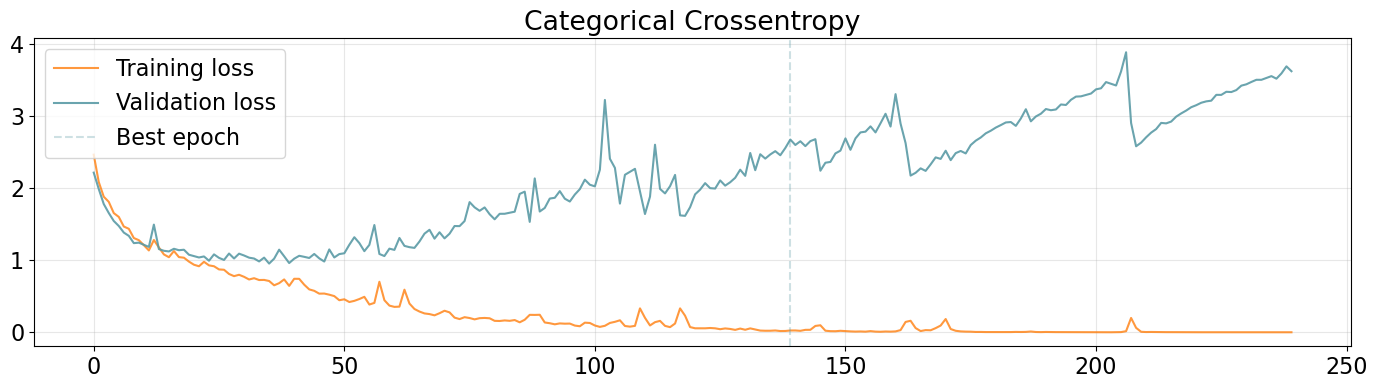

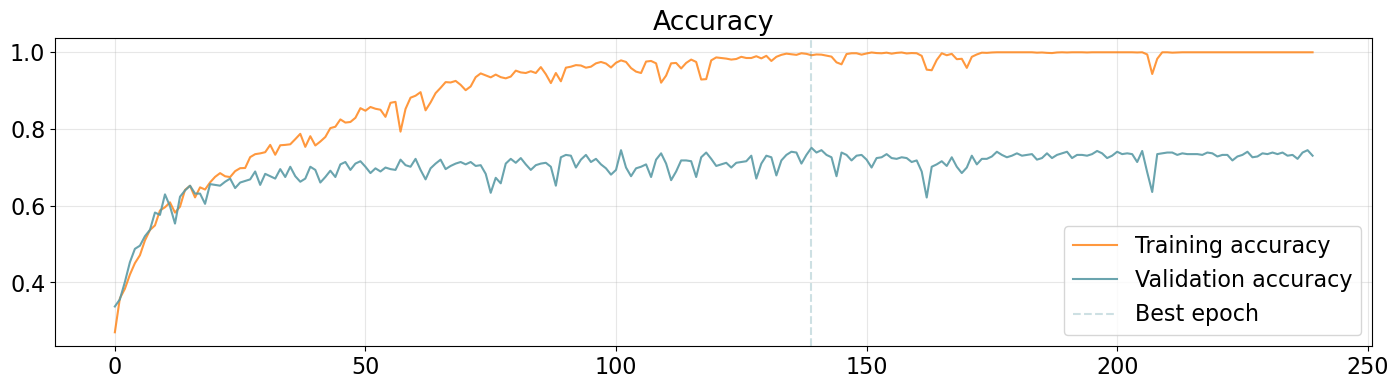

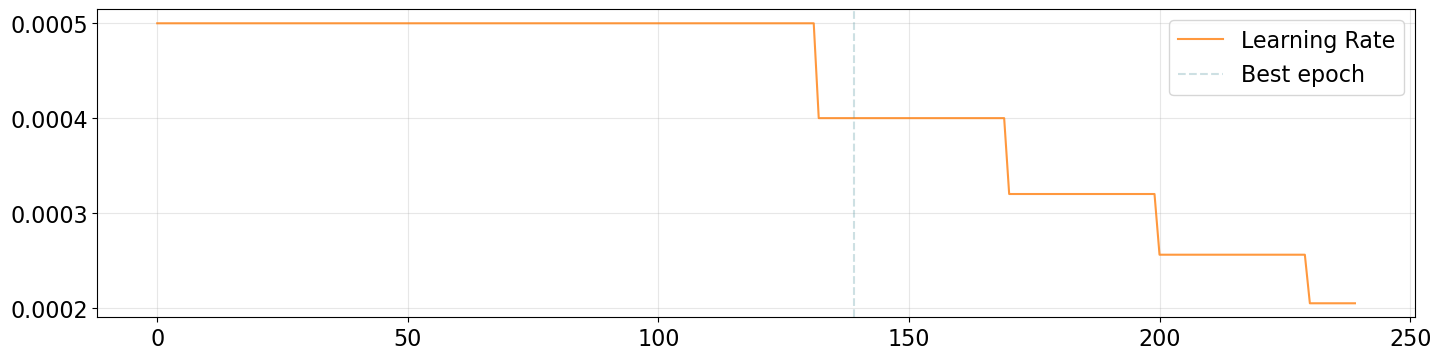

16/16 [==============================] - 0s 2ms/step
Accuracy: 0.751
Precision: 0.7261
Recall: 0.6199
F1: 0.6505


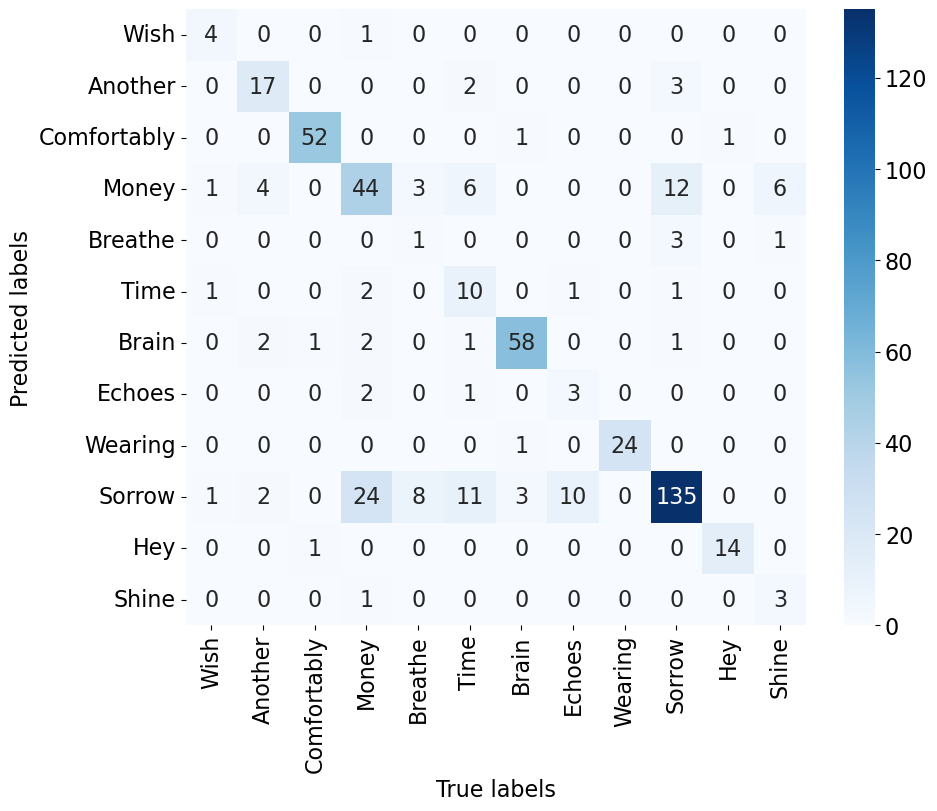

In [201]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_test, y_test),
    #class_weight=class_weights,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=100, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=30, factor=0.8, min_lr=1e-5)
    ]
).history

# Plot results
plot_history(history)
plot_cm(model)

#### Bidirectional Long Short Term Memory (BiLSTM) Neural Network

In [202]:
def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128))(bilstm)
    dropout = tfkl.Dropout(.5, seed=seed)(bilstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [203]:
model = build_BiLSTM_classifier(input_shape, classes)
model.summary() #note double number of parameters (this is because we have 2 lstm)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 bidirectional_38 (Bidirecti  (None, 36, 256)          138240    
 onal)                                                           
                                                                 
 bidirectional_39 (Bidirecti  (None, 256)              394240    
 onal)                                                           
                                                                 
 dropout_22 (Dropout)        (None, 256)               0         
                                                                 
 dense_32 (Dense)            (None, 128)               32896     
                                                                 
 dense_33 (Dense)            (None, 12)                1548  

In [204]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_test, y_test),
    class_weight=class_weights,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/700
61/61 [==============================] - 6s 28ms/step - loss: 2.3199 - accuracy: 0.1009 - val_loss: 2.3250 - val_accuracy: 0.1831 - lr: 0.0010
Epoch 2/700
61/61 [==============================] - 1s 12ms/step - loss: 2.0399 - accuracy: 0.1915 - val_loss: 2.2624 - val_accuracy: 0.0905 - lr: 0.0010
Epoch 3/700
61/61 [==============================] - 1s 12ms/step - loss: 1.9852 - accuracy: 0.2151 - val_loss: 2.0156 - val_accuracy: 0.2160 - lr: 0.0010
Epoch 4/700
61/61 [==============================] - 1s 12ms/step - loss: 1.8160 - accuracy: 0.2239 - val_loss: 2.0454 - val_accuracy: 0.1543 - lr: 0.0010
Epoch 5/700
47/61 [======================>.......] - ETA: 0s - loss: 1.7757 - accuracy: 0.2407

KeyboardInterrupt: 

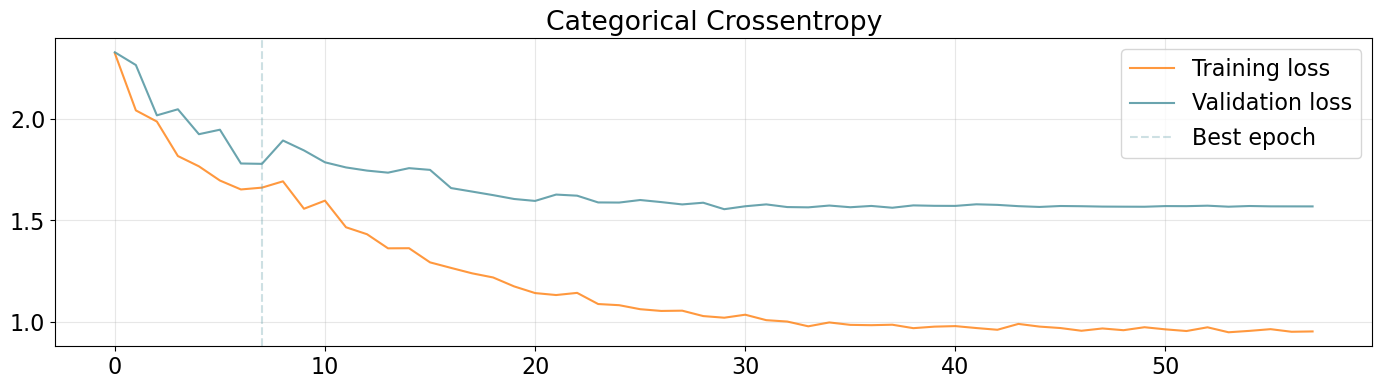

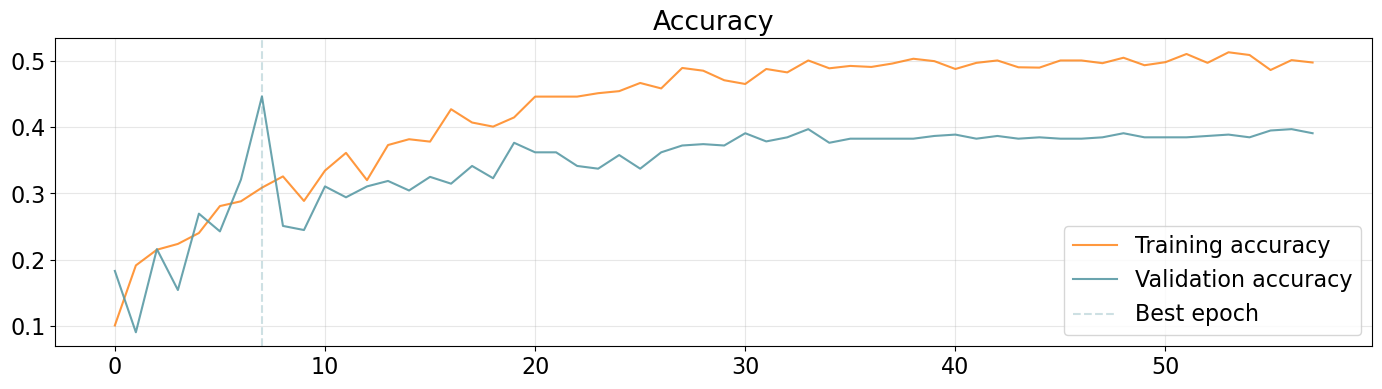

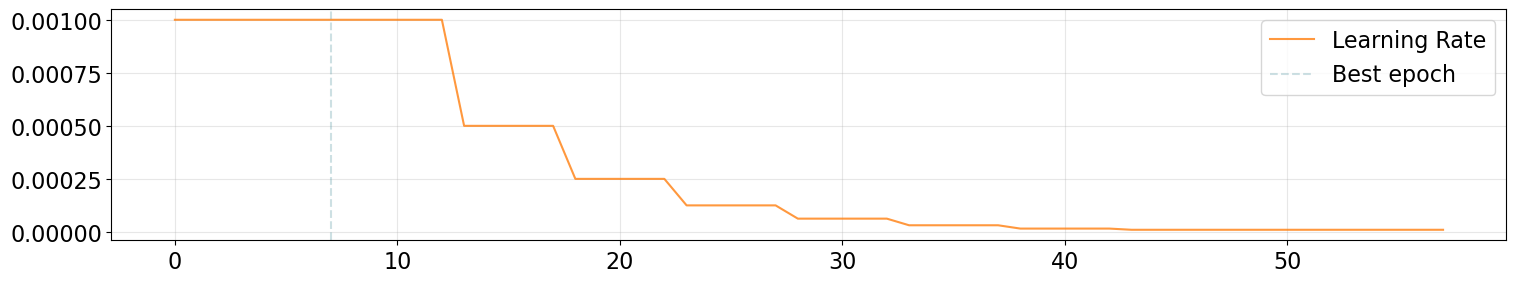

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# Predict the test set with the BiLSTM
predictions = model.predict(X_test)
predictions.shape

16/16 [==============================] - 1s 4ms/step


(486, 12)

Accuracy: 0.4465
Precision: 0.3567
Recall: 0.3881
F1: 0.3428


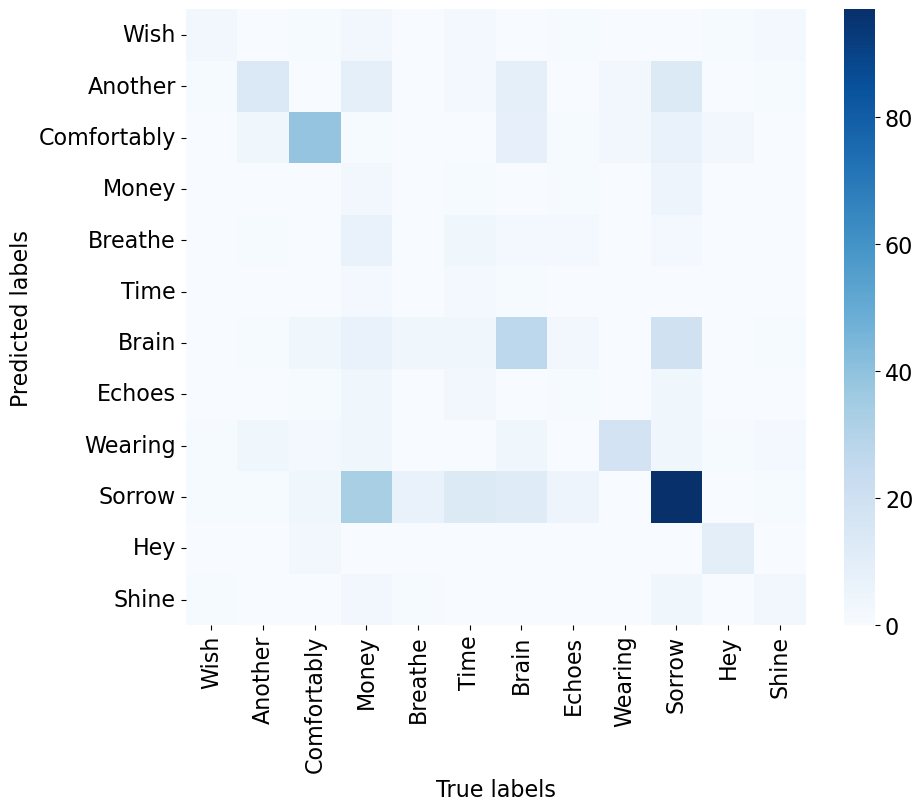

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

#### 1D Convolutional Neural Network

In [ ]:
def build_1DCNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.5, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
model = build_1DCNN_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 36, 128)           2432      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 18, 128)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 18, 128)           49280     
                                                                 
 global_average_pooling1d_2   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_20 (Dropout)        (None, 128)               0     

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_test, y_test),
    class_weight=class_weights,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/700
61/61 [==============================] - 1s 6ms/step - loss: 2.3692 - accuracy: 0.1539 - val_loss: 2.3795 - val_accuracy: 0.3292 - lr: 0.0010
Epoch 2/700
61/61 [==============================] - 0s 4ms/step - loss: 2.2789 - accuracy: 0.2491 - val_loss: 2.3198 - val_accuracy: 0.3354 - lr: 0.0010
Epoch 3/700
61/61 [==============================] - 0s 4ms/step - loss: 2.2217 - accuracy: 0.3453 - val_loss: 2.2489 - val_accuracy: 0.4239 - lr: 0.0010
Epoch 4/700
61/61 [==============================] - 0s 4ms/step - loss: 2.1177 - accuracy: 0.3042 - val_loss: 2.1682 - val_accuracy: 0.3889 - lr: 0.0010
Epoch 5/700
61/61 [==============================] - 0s 4ms/step - loss: 2.0271 - accuracy: 0.2440 - val_loss: 2.0962 - val_accuracy: 0.3992 - lr: 0.0010
Epoch 6/700
61/61 [==============================] - 0s 4ms/step - loss: 2.0569 - accuracy: 0.2280 - val_loss: 2.1023 - val_accuracy: 0.2037 - lr: 0.0010
Epoch 7/700
61/61 [==============================] - 0s 4ms/step - loss: 1.9

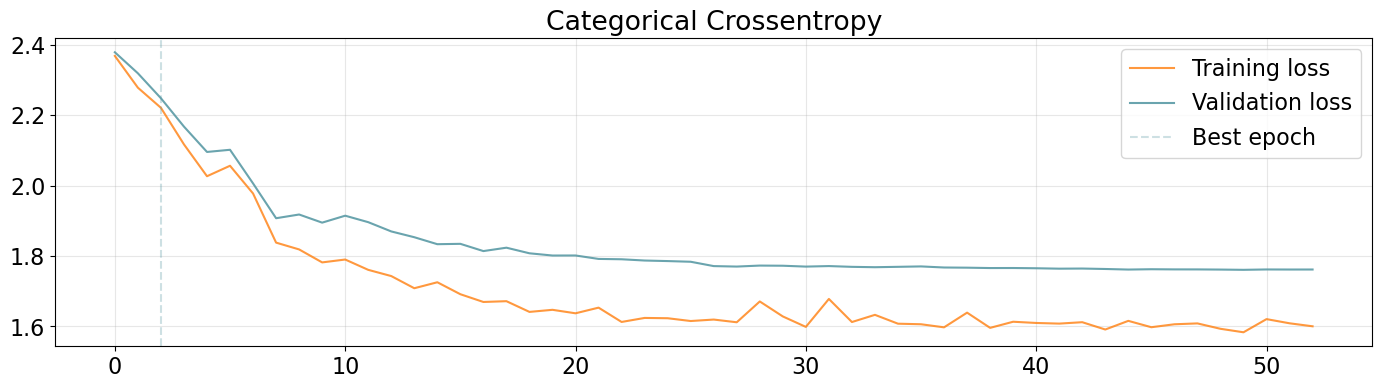

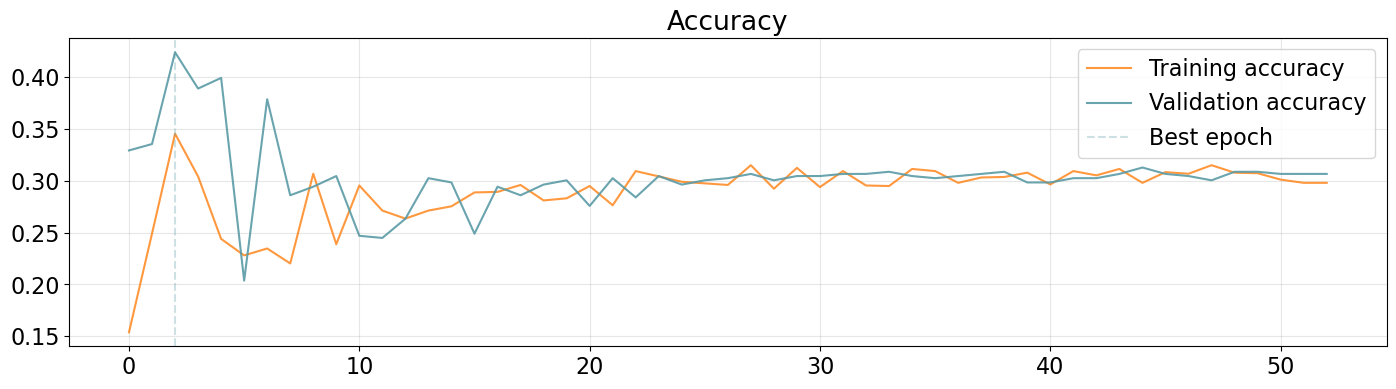

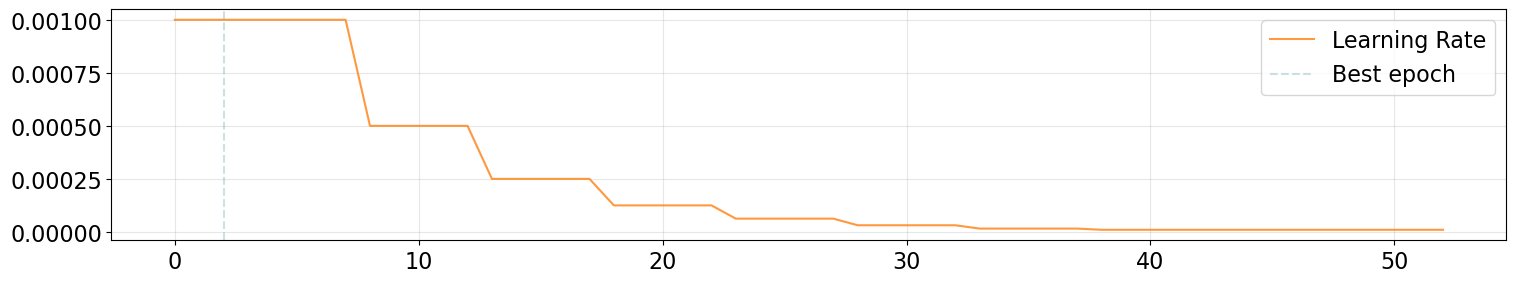

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# Predict the test set with the 1DCNN
predictions = model.predict(X_test)
predictions.shape

16/16 [==============================] - 0s 1ms/step


(486, 12)

Accuracy: 0.4239
Precision: 0.396
Recall: 0.3212
F1: 0.2816


c:\Users\Gabriele\miniconda3\envs\gputensorflow\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


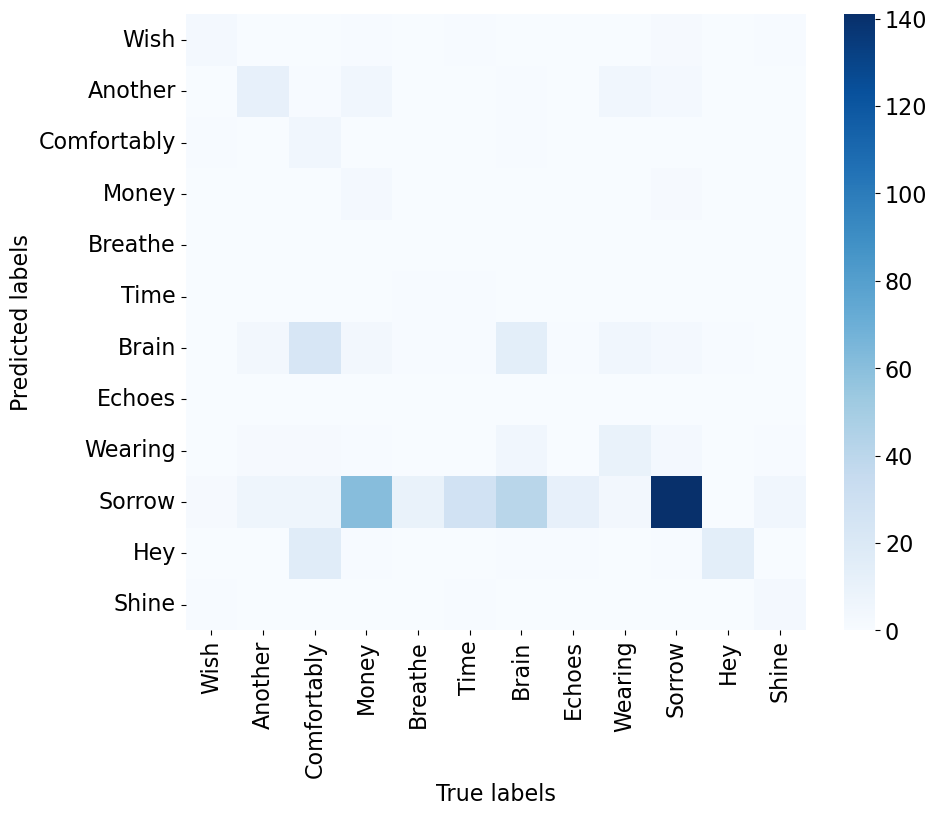

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()